In [13]:
import os
import yfinance as yf
import pandas as pd
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import feather
import pyarrow.parquet as pq
import pyarrow as pa


In [60]:
df = pd.read_csv('sp100.csv',index_col=0)
tickers =  [i.replace('.','-') for i in df.Symbol.to_list()]

file = 'datasets/sp100.parquet'
if not os.path.isfile(file):
    df = yf.download(tickers,start='2005-01-01',auto_adjust=True,progress=False)
    # Or use the monthly option
    # dl = yf.download(tickers, session=session, interval='1mo', start='2005-01-01')
    df.to_parquet('datasets/sp100.parquet')
df = pd.read_parquet('datasets/sp100.parquet')
df

Close                                                  \
                  AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2005-01-03    0.971844         NaN   14.956534   19.618639   30.838949   
2005-01-04    0.981825         NaN   14.805904   19.157375   30.024111   
2005-01-05    0.990424         NaN   14.636057   19.082981   29.859142   
2005-01-06    0.991192         NaN   14.966144   18.911869   29.364239   
2005-01-07    1.063362         NaN   15.222524   19.797201   29.384233   
...                ...         ...         ...         ...         ...   
2021-07-26  148.990005  117.790001  119.519997  318.980011  620.799988   
2021-07-27  146.770004  117.959999  119.809998  319.890015  618.280029   
2021-07-28  144.979996  118.550003  120.519997  316.309998  620.919983   
2021-07-29  145.639999  118.870003  121.089996  318.350006  621.700012   
2021-07-30  145.860001  116.300003  120.980003  317.679993  621.630005   

                                                                         ...  \
                   AIG        AMGN         AMT         AMZN        AVGO  ...   
Date                                                                     ...   
2005-01-03  873.705200   50.510906   15.225256    44.520000         NaN  ...   
2005-01-04  876.616089   49.709389   15.024044    42.139999         NaN  ...   
2005-01-05  891.171082   48.923599   14.889898    41.770000         NaN  ...   
2005-01-06  892.627014   49.379353   15.024044    41.049999         NaN  ...   
2005-01-07  894.214600   49.481529   15.292330    42.320000         NaN  ...   
...                ...         ...         ...          ...         ...  ...   
2021-07-26   47.709999  245.080002  284.609985  3699.820068  482.239990  ...   
2021-07-27   47.419998  244.679993  286.880005  3626.389893  475.359985  ...   
2021-07-28   46.950001  244.250000  284.980011  3630.320068  477.649994  ...   
2021-07-29   47.869999  242.460007  283.000000  3599.919922  484.109985  ...   
2021-07-30   47.349998  241.539993  282.799988  3327.590088  485.399994  ...   

             Volume                                                            \
                UNH      UNP       UPS      USB          V        VZ      WBA   
Date                                                                            
2005-01-03  6252600  7762400   2176500  5374600        NaN   9236061  9757800   
2005-01-04  5582000  8108400   3127400  4552700        NaN  11680234  6618200   
2005-01-05  4577600  5504800   2130700  5701600        NaN   8201616  6850200   
2005-01-06  4837600  5653600   1773600  4203000        NaN   7844458  4816400   
2005-01-07  6653200  3998000   2396900  5312700        NaN   8424450  2946400   
...             ...      ...       ...      ...        ...       ...      ...   
2021-07-26  2232600  2840900   2673700  3721700  4879000.0  15330500  4056600   
2021-07-27  2630600  3199000  13741500  4332400  7038300.0  15225800  5121300   
2021-07-28  2446600  2366200   6295500  4063600  9036500.0  14595900  3333800   
2021-07-29  1597300  1908000   3150300  7566000  7495300.0  12841900  3084600   
2021-07-30  1864200  2323500   3740300  6478400  5804200.0  13853500  9694300   

                                          
                 WFC       WMT       XOM  
Date                                      
2005-01-03   8168200  16078400  16009200  
2005-01-04   9241400  10596700  16718000  
2005-01-05   7694600   8241500  12189100  
2005-01-06   8887600  14028800  13098700  
2005-01-07   6573200   9660300  11315300  
...              ...       ...       ...  
2021-07-26  22976700   6172400  18387600  
2021-07-27  22124500   5131900  16861400  
2021-07-28  23252800   4690500  16855300  
2021-07-29  24487400   3687700  18607800  
2021-07-30  25792500   5441700  28641900  

[4173 rows x 505 columns]

In [61]:
prices = df.Close
prices.index = pd.to_datetime(prices.index)
monthly_rets = prices.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)


In [ ]:
# Make a data frame with prior months as a column
formation_dt = dt.datetime(2009,2,28)
formation_dt = dt.datetime(2021,7,31)
prior_monthly_rets = pd.DataFrame({'returns':monthly_rets.loc[formation_dt - MonthEnd(1)]})

# Bucket returns
prior_monthly_rets['decile'] = pd.qcut(prior_monthly_rets.returns, 20, labels=False)

In [18]:
losers = prior_monthly_rets[prior_monthly_rets.decile == 0].index
losers_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(losers)].mean()
losers_ret

-0.2571558902685344

In [71]:
def monthly_decile(formation_dt, decile, monthly_rets):
    df = monthly_rets.loc[formation_dt - MonthEnd(1)].copy()
    df.name = 'returns'
    df = pd.DataFrame(df)
    df['decile'] = pd.qcut(df.returns, 20, labels=False, duplicates='drop')
    symbols = df[df.decile == decile].index
    decile_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(symbols)].mean()
    return decile_ret, symbols.values.tolist()

import datetime as dt
start_dt = dt.datetime(2021,7,31)
print(f'Date: {formation_dt}')
for i in range(0,20): 
    ret, symbols = monthly_decile(formation_dt, i, monthly_rets)
    print(f'bin{i:02d} ret: {ret:+2.2%} symbols={symbols}')
# 
# prices.resample('M').last()[['AAPL', 'COP', 'MSFT', 'PYPL', 'TSLA']][-1:]

Date: 2021-07-31 00:00:00
bin00 ret: -2.79% symbols=['AIG', 'C', 'CAT', 'DD', 'DOW', 'MET']
bin01 ret: -0.99% symbols=['BKNG', 'JPM', 'KHC', 'SO', 'USB']
bin02 ret: -0.26% symbols=['BRK-B', 'FDX', 'GE', 'HON', 'RTX']
bin03 ret: +0.72% symbols=['COF', 'CVS', 'LIN', 'UPS', 'WFC']
bin04 ret: -1.34% symbols=['BA', 'BAC', 'CL', 'JNJ', 'UNH']
bin05 ret: +2.52% symbols=['EXC', 'MMM', 'SBUX', 'T', 'UNP']
bin06 ret: +1.79% symbols=['BK', 'DIS', 'DUK', 'INTC', 'MDT']
bin07 ret: +4.98% symbols=['KO', 'MCD', 'MDLZ', 'MO', 'ORCL']
bin08 ret: +1.91% symbols=['ABT', 'GD', 'LMT', 'VZ', 'WMT']
bin09 ret: -1.31% symbols=['ABBV', 'CMCSA', 'GM', 'LOW', 'WBA']
bin10 ret: +3.63% symbols=['BLK', 'CSCO', 'EMR', 'HD', 'PG']
bin11 ret: +5.04% symbols=['CVX', 'MS', 'NEE', 'PEP', 'PFE']
bin12 ret: +1.53% symbols=['AVGO', 'BMY', 'MA', 'SPG', 'TXN']
bin13 ret: -2.53% symbols=['AMGN', 'F', 'GS', 'IBM', 'TMUS']
bin14 ret: +4.28% symbols=['AXP', 'CHTR', 'CRM', 'GOOGL', 'V']
bin15 ret: +7.33% symbols=['ACN', 'COST', 'D

In [ ]:
returns = []
dates = monthly_rets[2:].index

for dt in dates:
    decile_returns = []
    returns.append(decile_returns)
    for decile in range(0,20):
        decile_returns.append(monthly_decile(dt, decile, monthly_rets)[0])

df = pd.DataFrame(returns)
df.index = dates
df.to_csv('wip.csv')
#print(df.tail())
df.describe()

In [80]:
spy = yf.download('SPY',start='2005-01-01', progress=False)
spy = spy['Adj Close']
spy_rets = spy.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)
df['spy']  = spy_rets[2:].values
df.to_csv('wip.csv')

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       'spy'],
      dtype='object')


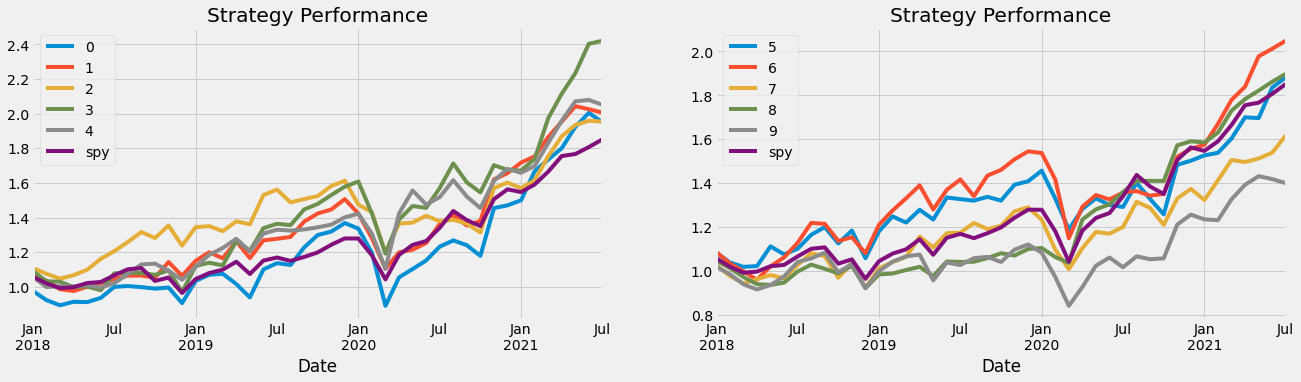

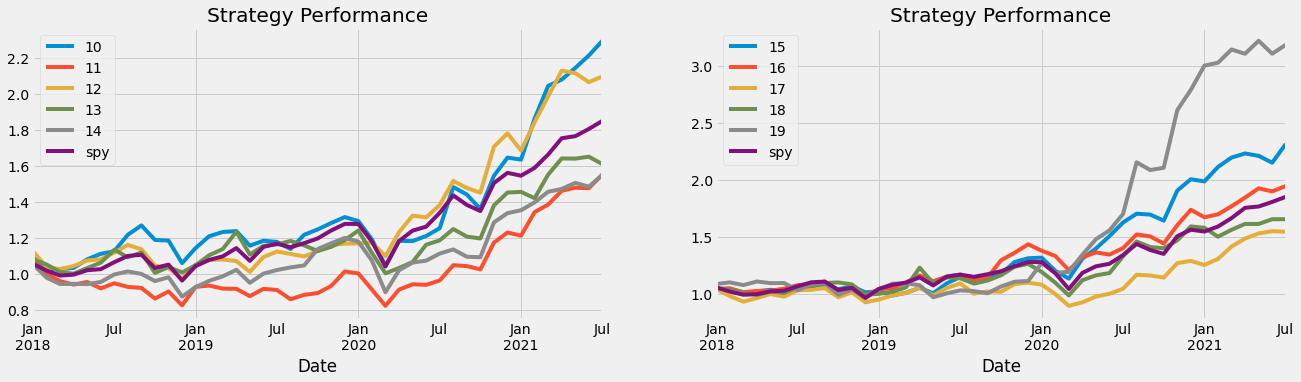

In [80]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
print(df.columns)
subplots_ratio = dict(width_ratios=[3,3], height_ratios=[1])

bins1 = ['0', '1', '2', '3', '4', 'spy']
bins2 = ['5', '6', '7', '8', '9', 'spy']
bins3 = ['10', '11', '12', '13', '14', 'spy']
bins4 = ['15', '16', '17', '18', '19', 'spy']

xdf = pd.read_csv('wip.csv', index_col='Date', parse_dates=True)
xdf = xdf[xdf.index > '2018-01-01']

fig, ax = plt.subplots(1,2, gridspec_kw=subplots_ratio, figsize=(20,5))
xdf[bins1].cumsum().apply(np.exp).plot(title='Strategy Performance',ax=ax[0])
xdf[bins2].cumsum().apply(np.exp).plot(title='Strategy Performance',ax=ax[1])

fig, ax = plt.subplots(1,2, gridspec_kw=subplots_ratio, figsize=(20,5))
xdf[bins3].cumsum().apply(np.exp).plot(title='Strategy Performance',ax=ax[0])
xdf[bins4].cumsum().apply(np.exp).plot(title='Strategy Performance',ax=ax[1])

#xdf[bins].cumsum().plot(title='Strategy Performance',ax=ax[1])

#df.plot.hist(title='Returns Distribution', ax=ax[1], grid=True, bins=30)
#df.plot
plt.show()